In [32]:
import numpy as np
import blip_analysis as ba
import matplotlib.pyplot as plt
import pickle
import scipy
from tqdm import trange
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
import dask
from scipy.optimize import minimize
import daskify

In [2]:
dasked = daskify.Daskified(memory='16GB', size=15)
dasked.start_cluster()

In [3]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [4]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
model_length = 130

In [5]:
### Loading responsive cells from the 230509_fig5_2PCs.ipynb - only cells which are 'responsive' to all three odours
responsive_only_cells = np.load('../Fig5/230515_all_responsive_cells.npy')
diff_models1 = diff_models1[responsive_only_cells]
diff_models2 = diff_models2[responsive_only_cells]
diff_models3 = diff_models3[responsive_only_cells]
model_length = 66

In [6]:
[i.fit() for i in diff_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [7]:
diff_ws1 = [i.opt_out.x[:-1] for i in diff_models1]
diff_ws2 = [i.opt_out.x[:-1] for i in diff_models2]
diff_ws3 = [i.opt_out.x[:-1] for i in diff_models3]

preds1 = [i.pred_resp for i in diff_models1]
preds2 = [i.pred_resp for i in diff_models2]
preds3 = [i.pred_resp for i in diff_models3];

trues1 = [i.true_resp for i in diff_models1]
trues2 = [i.true_resp for i in diff_models2]
trues3 = [i.true_resp for i in diff_models3];

In [8]:
mean_usrt1 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
std_usrt1 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
mean_usrt2 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
std_usrt2 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
mean_usrt3 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
std_usrt3 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]

In [9]:
diff_models_scattered1 = dasked.client.scatter(diff_models1)
diff_models_scattered2 = dasked.client.scatter(diff_models2)
diff_models_scattered3 = dasked.client.scatter(diff_models3)

diff_ws_scattered1 = dasked.client.scatter(diff_ws1)
diff_ws_scattered2 = dasked.client.scatter(diff_ws2)
diff_ws_scattered3 = dasked.client.scatter(diff_ws3)

In [10]:
def other_odour_loss(ats, model, weights):
    #print(weights)
    changed_ws = weights*ats[0]
    changed_ws = np.append(changed_ws, ats[1])
    #print(changed_ws)
    model.fit(W=changed_ws)
    return model.loss(model.pred_resp, model.true_resp)

In [11]:
def find_all_fits(models, alternative_ws, ui, tqdm=False):
    preds = []
    scores = []
    for i in trange(len(models), position=0, leave=False, disable=tqdm):
        opt = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(models[ui], alternative_ws[i]), method='Nelder-Mead')
        appended = np.append(alternative_ws[i]*opt.x[0], opt.x[1])
        models[ui].fit(W=appended)
        preds.append(models[ui].pred_resp)
        fit_score = np.mean((models[ui].pred_resp - models[ui].true_resp)**2)/np.std(models[ui].true_resp)**2
        #print(models[ui].fit_score, fit_score)
        scores.append(models[ui].fit_score)

    return preds, scores

#cell_preds, scores = find_all_fits(diff_models1, diff_ws2, 40)


In [12]:
dask_outs = []
weight_types = [[diff_ws_scattered2, diff_ws_scattered3], [diff_ws_scattered1, diff_ws_scattered3], [diff_ws_scattered1, diff_ws_scattered2]]

for index, model_type in enumerate([diff_models_scattered1, diff_models_scattered2, diff_models_scattered3]):
    for weights in weight_types[index]:
        for ui in range(model_length):
            dask_outs.append(dask.delayed(find_all_fits)(model_type, weights, ui, tqdm=False))
dask_futures = dasked.client.compute(dask_outs)
dasked.current_futures = dask_futures

In [26]:
dasked.check_progress()

finished 396


In [27]:
res = dasked.collect_results()

res = np.array(res)
res = res.reshape(3, 2, model_length, 2, model_length)

In [28]:
cell_preds12 = res[0, 0, :, 0, :]
scores12 = res[0, 0, :, 1, :]
cell_preds13 = res[0, 1, :, 0, :]
scores13 = res[0, 1, :, 1, :]


cell_preds21 = res[1, 0, :, 0, :]
scores21 = res[1, 0, :, 1, :]
cell_preds23 = res[1, 1, :, 0, :]
scores23 = res[1, 1, :, 1, :]
cell_preds31 = res[2, 0, :, 0, :]
scores31 = res[2, 0, :, 1, :]
cell_preds32 = res[2, 1, :, 0, :]
scores32 = res[2, 1, :, 1, :]

54
36
58
55
46
62
42
48
55


Text(0.5, 1.0, 'Odour 3')

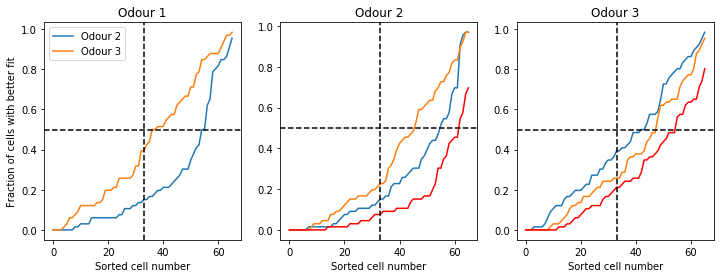

In [29]:
def plot_score_fracs(scores1, scores2, odour1_label='Odour 1', odour2_label='Odour 2', ax=None, colors=['C0', 'C1', 'r'], show_best=True):
    scores_frac1 = []
    scores_frac2 = []
    for i in range(model_length):
        self_score1 = scores1[i][i]
        self_score2 = scores2[i][i]
        scores_frac1.append(len(np.where(np.array(scores1)[i] < self_score1)[0])/model_length)
        scores_frac2.append(len(np.where(np.array(scores2)[i] < self_score2)[0])/model_length)
    min_score_fracs = np.min([scores_frac1, scores_frac2], axis=0)
    best_odour_fracs = np.array([scores_frac1, scores_frac2]).argmin(axis=0)

    frac_args1 = np.argsort(scores_frac1)
    frac_args2 = np.argsort(scores_frac2)
    minfracs_args = np.argsort(min_score_fracs)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(np.array(scores_frac1)[frac_args1], label=odour1_label, color=colors[0])
    ax.plot(np.array(scores_frac2)[frac_args2], label=odour2_label, color=colors[1])
    if show_best:
        ax.plot(np.array(min_score_fracs)[minfracs_args], label='Min of both odours', color=colors[2])
    ax.axhline(0.5, color='k', linestyle='--')
    ax.set_xlabel('Sorted cell number')
    ax.set_ylabel('Fraction of cells with better fit')
    ax.axvline(int(model_length/2), color='k', linestyle='--')

    print(len(np.where(np.array(scores_frac1) < 0.5)[0]))
    print(len(np.where(np.array(scores_frac2) < 0.5)[0]))
    print(len(np.where(np.array(min_score_fracs) < 0.5)[0]))
    fracs = [len(np.where(np.array(scores_frac1) < 0.5)[0]), len(np.where(np.array(scores_frac2) < 0.5)[0]), len(np.where(np.array(min_score_fracs) < 0.5)[0])]
    joint_args = [frac_args1, frac_args2, minfracs_args]
    return ax, fracs, joint_args
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax0, fracs1, sorted_args1 = plot_score_fracs(scores12, scores13, odour1_label='Odour 2', odour2_label='Odour 3', ax=ax[0], show_best=False)
ax1, fracs2, sorted_args2 = plot_score_fracs(scores21, scores23, odour1_label='Odour 1', odour2_label='Odour 3', ax=ax[1])
ax2, fracs3, sorted_args3 = plot_score_fracs(scores31, scores32, odour1_label='Odour 1', odour2_label='Odour 2', ax=ax[2])
ax0.legend()
ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax0.set_title('Odour 1')
ax1.set_title('Odour 2')
ax2.set_title('Odour 3')

In [33]:
corrs = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt1, mean_usrt2)]
print(np.argsort(np.abs(corrs)))
corr_args = np.argsort(np.abs(corrs))

[ 3 51 41 12  4 24  2 63 31 52 49 53 21 44  6 47 22 25 64 10 43 36 16 13
 11 58 15 60 56 23 20  5 55 54 17 62 48  8 59  0 50  1 57 18 45  9 33 26
 14 35 30 46 29 28 42 38 19 65 61 27  7 40 37 32 39 34]


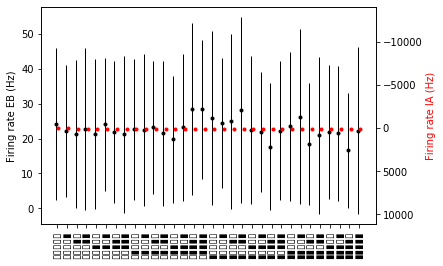

In [35]:

def auto_scale(odour1, odour2, ui):
    data1 = np.array(odour1[ui])
    data2 = np.array(odour2[ui])

    x_data = np.array(range(32))
    init_limits = [0, 100]

    result = minimize(calc_diff, init_limits, args=(data1, data2), method='Nelder-Mead', tol=1e-20, options={'maxiter': 10000})
    return result.x

def calc_diff(limits, data1, data2):
    lower, upper = limits
    
    # Rescale data
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    #scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    
    # Calculate sum of squared differences
    diff = np.sum((data1 - scaled_data2)**2)
    return diff


def plot_multi_odour_response2(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False):
    data1 = np.array(odour1[cell_index])
    data2 = np.array(odour2[cell_index])
    lower, upper = auto_scale(odour1, odour2, cell_index)
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    scaled_err = (upper - lower) / (np.max(data2) - np.min(data2)) * np.array(odour2_std[cell_index])

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.errorbar(np.arange(0, 64, 2), data1, yerr=odour1_std[cell_index], fmt='.', color='k', linewidth=1)
    ax.errorbar(np.arange(0.5, 64.5, 2), scaled_data2, yerr=scaled_err, fmt='.', color='r', linewidth=1)
    ax.set_xticks(np.arange(0.25, 64.25, 2))
    ax.set_xticklabels(glyphs, rotation=90);
    ylims = ax.get_ylim()
    ax2 = ax.twinx()
    scaled_ylims = ((np.array(ylims) - lower) * (np.max(data2) - np.min(data2)) / (upper - lower)) + np.min(data2)
    ax2.set_ylim(scaled_ylims)
    ax2.set_ylabel('Firing rate IA (Hz)', color='r')
    ax.set_ylabel('Firing rate EB (Hz)')

plot_multi_odour_response2(corr_args[0], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2)

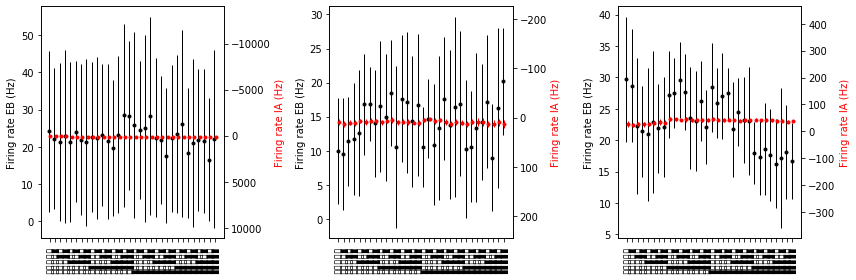

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plot_multi_odour_response2(corr_args[0], mean_usrt1, mean_usrt2, ax=ax[0], odour1_std=std_usrt1, odour2_std=std_usrt2)
plot_multi_odour_response2(corr_args[1], mean_usrt1, mean_usrt2, ax=ax[1], odour1_std=std_usrt1, odour2_std=std_usrt2)
plot_multi_odour_response2(corr_args[2], mean_usrt1, mean_usrt2, ax=ax[2], odour1_std=std_usrt1, odour2_std=std_usrt2)
plt.tight_layout()
plt.savefig('230703_badly_fit_cells.pdf', bbox_inches='tight')

In [44]:
print(np.std(mean_usrt1[corr_args[-1]]))
print(np.std(mean_usrt2[corr_args[-1]]))

5.022210651335614
23.904201164927752


In [50]:
print(np.max(mean_usrt1[corr_args[0]])-np.min(mean_usrt1[corr_args[0]]))
print(np.max(mean_usrt2[corr_args[0]])-np.min(mean_usrt2[corr_args[0]]))

11.866666666666664
111.8


In [54]:
print(np.mean(std_usrt1[corr_args[0]]))
print(np.mean(std_usrt2[corr_args[-1]]))

20.95450015912254
12.73615765865871


0.29327789612276745 0.37096084191630185


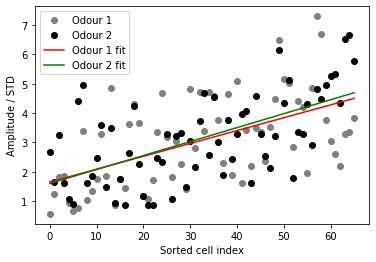

In [83]:
diffs1 = []
diffs2 = []

for ui in corr_args:
    diffs1.append((np.max(mean_usrt1[ui])-np.min(mean_usrt1[ui]))/np.mean(std_usrt1[ui]))
    diffs2.append((np.max(mean_usrt2[ui])-np.min(mean_usrt2[ui]))/np.mean(std_usrt2[ui]))
bf1 = np.poly1d(np.polyfit(range(66), diffs1, 1))
bf2 = np.poly1d(np.polyfit(range(66), diffs2, 1))
plt.plot(diffs1, 'o', color='gray', label='Odour 1')
plt.plot(diffs2, 'o', color='k', label='Odour 2')

plt.plot(range(66), bf1(range(66)), color='r', label='Odour 1 fit')
plt.plot(range(66), bf2(range(66)), color='g', label='Odour 2 fit')
s, i, r1, p, serr =scipy.stats.linregress(range(66), diffs1)
s, i, r2, p, serr =scipy.stats.linregress(range(66), diffs2)
plt.legend()
print(r1**2, r2**2)
plt.xlabel('Sorted cell index')
plt.ylabel('Amplitude / STD')
plt.savefig('230703_cell_fit_vs_responsivity.pdf', bbox_inches='tight')

In [73]:
scipy.stats.linregress(range(66), diffs1)

LinregressResult(slope=0.04382788878126542, intercept=1.653049387799393, rvalue=0.5415513790239735, pvalue=2.6596179361894717e-06, stderr=0.008504430478083773, intercept_stderr=0.3203774469270868)